## 1- Import Libraries

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from google.colab import files
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

## 2- Upload Dataset

In [2]:
print("Please upload your file.")
uploaded = files.upload()

Please upload your file.


Saving CarPrice_Assignment.csv to CarPrice_Assignment.csv


### load dataset

In [3]:
file_name = 'CarPrice_Assignment.csv'

try:
    data = pd.read_csv(file_name)
    print("Data loaded successfully. Type of 'data':", type(data))
    print("First few rows of data:\n", data.head())
except Exception as e:
    print(f"Error loading CSV: {e}")
    exit()

Data loaded successfully. Type of 'data': <class 'pandas.core.frame.DataFrame'>
First few rows of data:
    car_ID  symboling                   CarName fueltype aspiration doornumber  \
0       1          3        alfa-romero giulia      gas        std        two   
1       2          3       alfa-romero stelvio      gas        std        two   
2       3          1  alfa-romero Quadrifoglio      gas        std        two   
3       4          2               audi 100 ls      gas        std       four   
4       5          2                audi 100ls      gas        std       four   

       carbody drivewheel enginelocation  wheelbase  ...  enginesize  \
0  convertible        rwd          front       88.6  ...         130   
1  convertible        rwd          front       88.6  ...         130   
2    hatchback        rwd          front       94.5  ...         152   
3        sedan        fwd          front       99.8  ...         109   
4        sedan        4wd          front       9

## 3- Preprocess Data

In [4]:
X = data.drop(columns=['car_ID', 'CarName'])
y = data['price']

mean_price = y.mean()

print(f"Mean Price: {mean_price:.2f}")

Mean Price: 13276.71


### Encode Categorical Variables

In [5]:
categorical_cols = X.select_dtypes(include=['object']).columns
for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])

### Train/Test Split

15% test / 85% train+val

In [6]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

### Scale Features

In [7]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

## 4- Visualization: fuel type histogram

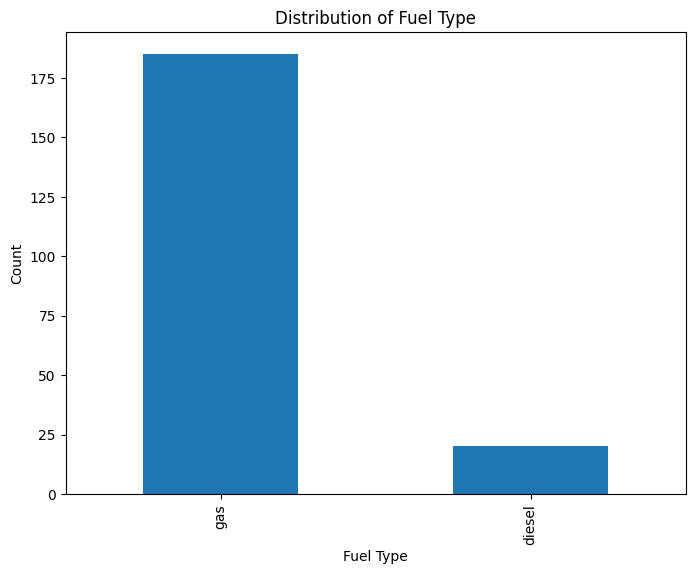

In [8]:
plt.figure(figsize=(8, 6))

data['fueltype'].value_counts().plot(kind='bar')
plt.title('Distribution of Fuel Type')
plt.xlabel('Fuel Type')
plt.ylabel('Count')

plt.show()

In [9]:
def get_performance_metric(test_mae, y_true, y_pred, mean_price):

    if test_mae > mean_price:
        r2 = r2_score(y_true, y_pred)
        return f"R²: {r2:.4f} (MAE > Mean Price)"
    else:
        accuracy = 100 - (test_mae / mean_price * 100)
        return f"Accuracy: {accuracy:.2f}%"

## 5- Optimized Deep Neural Network

In [10]:
def build_optimized_model():

    model = keras.Sequential([
        layers.Input(shape=(X_train.shape[1],)),
        layers.Dense(128, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(1)
    ])

    model.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError(), 'mae'])
    return model

opt_model = build_optimized_model()
history = opt_model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), batch_size=32, verbose=0)

### Calculate Metrics

In [11]:
y_test_pred = opt_model.predict(X_test, verbose=0)

test_mse = mean_squared_error(y_test, y_test_pred)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(y_test, y_test_pred)

opt_metric = get_performance_metric(test_mae, y_test, y_test_pred, mean_price)

print("\nOptimized Model Metrics:")
print(f"Test RMSE: {test_rmse:.2f}")
print(f"Test MAE: {test_mae:.2f}")
print(f"Performance: {opt_metric}")


Optimized Model Metrics:
Test RMSE: 3222.96
Test MAE: 2534.53
Performance: Accuracy: 80.91%


### Plot loss and metrics

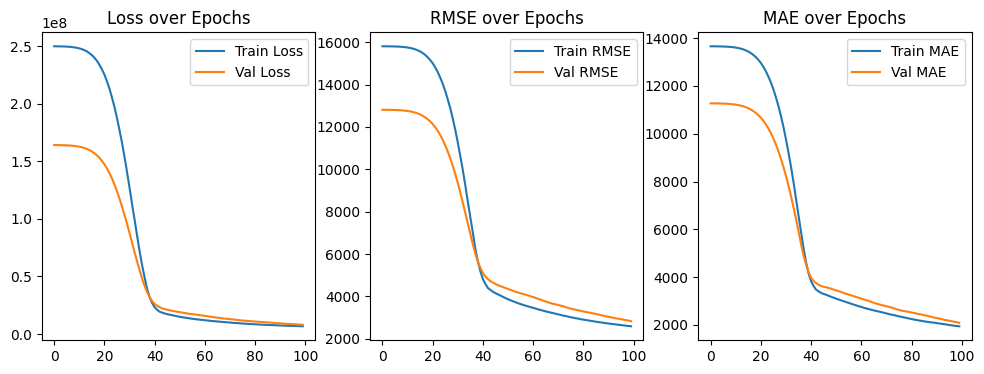

In [12]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(history.history['root_mean_squared_error'], label='Train RMSE')
plt.plot(history.history['val_root_mean_squared_error'], label='Val RMSE')
plt.title('RMSE over Epochs')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.title('MAE over Epochs')
plt.legend()

plt.show()

## 6- Single Layer with Varying Neurons

In [13]:
neuron_counts = [50, 100, 200, 350, 500]
mae_results_neurons = []

for neurons in neuron_counts:
    model = keras.Sequential([
        layers.Input(shape=(X_train.shape[1],)),
        layers.Dense(neurons, activation='relu'),
        layers.Dense(1)
    ])

    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    history = model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), batch_size=32, verbose=0)
    min_mae = min(history.history['val_mae'])
    mae_results_neurons.append(min_mae)

    test_pred = model.predict(X_test, verbose=0)
    test_mae = mean_absolute_error(y_test, test_pred)
    metric = get_performance_metric(test_mae, y_test, test_pred, mean_price)

    print(f"Neurons: {neurons}, Min Validation MAE: {min_mae:.2f}, Test MAE: {test_mae:.2f}, Performance: {metric}")

Neurons: 50, Min Validation MAE: 11216.88, Test MAE: 13737.22, Performance: R²: -2.0996 (MAE > Mean Price)
Neurons: 100, Min Validation MAE: 11163.28, Test MAE: 13638.28, Performance: R²: -2.0450 (MAE > Mean Price)
Neurons: 200, Min Validation MAE: 11024.12, Test MAE: 13402.43, Performance: R²: -1.9263 (MAE > Mean Price)


Neurons: 350, Min Validation MAE: 10783.93, Test MAE: 13056.73, Performance: Accuracy: 1.66%


Neurons: 500, Min Validation MAE: 10555.98, Test MAE: 12697.27, Performance: Accuracy: 4.36%


### plot MAE vs Neurons

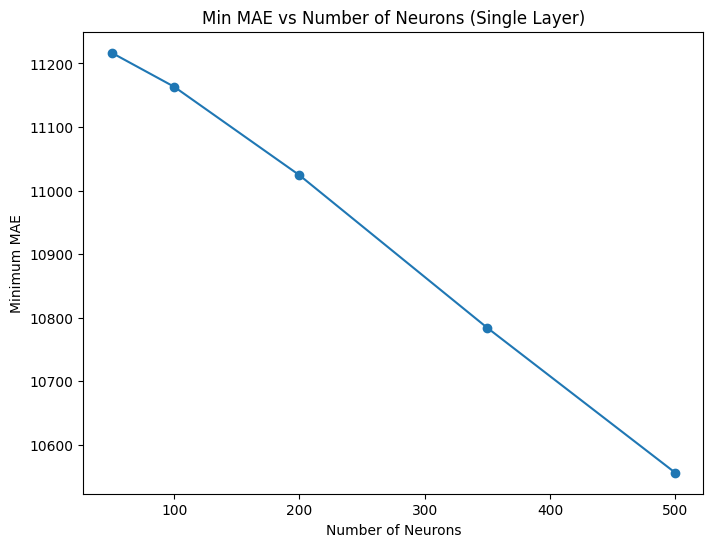

In [14]:
plt.figure(figsize=(8, 6))
plt.plot(neuron_counts, mae_results_neurons, marker='o')

plt.title('Min MAE vs Number of Neurons (Single Layer)')
plt.xlabel('Number of Neurons')
plt.ylabel('Minimum MAE')

plt.show()
plt.close()

## 7- Varying Layer with 100 Neurons

In [15]:
layer_counts = [1, 2, 5, 7]
mae_results_layers = []

for layers_count in layer_counts:
    model = keras.Sequential([layers.Input(shape=(X_train.shape[1],))])

    for _ in range(layers_count):
        model.add(layers.Dense(100, activation='relu'))

    model.add(layers.Dense(1))
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])

    history = model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), batch_size=32, verbose=0)

    min_mae = min(history.history['val_mae'])
    mae_results_layers.append(min_mae)

    test_pred = model.predict(X_test, verbose=0)
    test_mae = mean_absolute_error(y_test, test_pred)
    metric = get_performance_metric(test_mae, y_test, test_pred, mean_price)

    print(f"Layers: {layers_count}, Min Validation MAE: {min_mae:.2f}, Test MAE: {test_mae:.2f}, Performance: {metric}")

Layers: 1, Min Validation MAE: 11173.41, Test MAE: 13644.36, Performance: R²: -2.0473 (MAE > Mean Price)
Layers: 2, Min Validation MAE: 4199.35, Test MAE: 4015.28, Performance: Accuracy: 69.76%
Layers: 5, Min Validation MAE: 880.88, Test MAE: 1433.68, Performance: Accuracy: 89.20%
Layers: 7, Min Validation MAE: 791.94, Test MAE: 1218.11, Performance: Accuracy: 90.83%


### plot MAE vs Layers

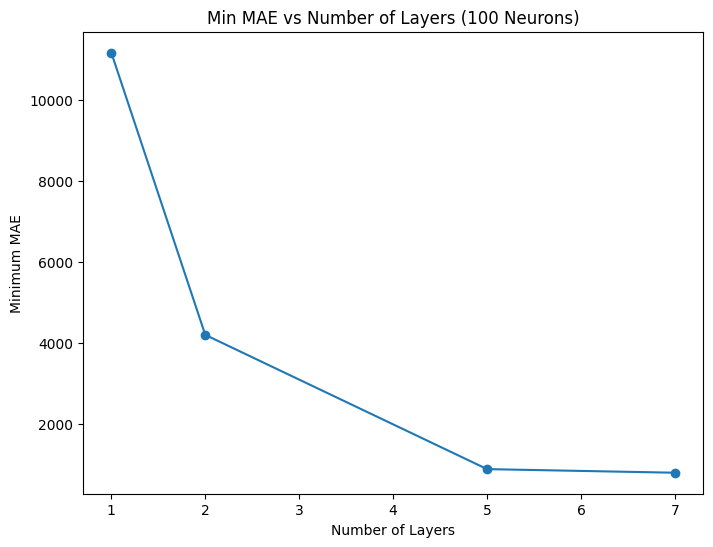

In [16]:
plt.figure(figsize=(8, 6))

plt.plot(layer_counts, mae_results_layers, marker='o')
plt.title('Min MAE vs Number of Layers (100 Neurons)')
plt.xlabel('Number of Layers')
plt.ylabel('Minimum MAE')

plt.show()
plt.close()

## 8- Wide-and-Deep Model

In [17]:
inputs = layers.Input(shape=(X_train.shape[1],))

wide = layers.Dense(128, activation='relu')(inputs)
deep = layers.Dense(128, activation='relu')(inputs)
deep = layers.Dense(64, activation='relu')(deep)
deep = layers.Dense(32, activation='relu')(deep)

combined = layers.concatenate([wide, deep])
combined = layers.Dropout(0.2)(combined)
output = layers.Dense(1)(combined)

wide_deep_model = keras.Model(inputs, output)
wide_deep_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

history_wd = wide_deep_model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), batch_size=32, verbose=0)

### Compare with Optimized Deep Model

In [18]:
opt_pred = opt_model.predict(X_test, verbose=0)
wd_pred = wide_deep_model.predict(X_test, verbose=0)

opt_mae = mean_absolute_error(y_test, opt_pred)
wd_mae = mean_absolute_error(y_test, wd_pred)

opt_metric = get_performance_metric(opt_mae, y_test, opt_pred, mean_price)
wd_metric = get_performance_metric(wd_mae, y_test, wd_pred, mean_price)

print("\nComparison:")
print(f"Optimized Deep Model Test MAE: {opt_mae:.2f}, Performance: {opt_metric}")
print(f"Wide-and-Deep Model Test MAE: {wd_mae:.2f}, Performance: {wd_metric}")


Comparison:
Optimized Deep Model Test MAE: 2534.53, Performance: Accuracy: 80.91%
Wide-and-Deep Model Test MAE: 2763.72, Performance: Accuracy: 79.18%
